<a href="https://colab.research.google.com/github/njadux/News-Category-Classification/blob/main/News_Category_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# basic libs
!pip install pandas numpy scikit-learn matplotlib seaborn nltk spacy wordcloud joblib

# recommended for dataset + boosted models + NN
!pip install datasets xgboost lightgbm tensorflow

# for spaCy lemmatization
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 101.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from wordcloud import WordCloud
from collections import Counter

import joblib
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


# Read CSVs, combine title+description, fix labels

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [5]:
train_df.head(200)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
195,4,Britons embrace digital lifestyle,People in the UK are spending more time and mo...
196,4,PlayStation potential to learning,The PlayStation games console could be develop...
197,4,'Invisible' technology for Olympics,Getting the technology in place for Athens 200...
198,4,Satellite boosts Olympic security,An enhanced satellite location system aims to ...


In [6]:
# Combine title + description
train_df['text'] = train_df['Title'] +  " " + train_df['Description']
test_df['text'] = test_df['Title'] + " " + test_df['Description']

In [7]:
print(train_df[["Class Index", "text"]].head())

   Class Index                                               text
0            3  Wall St. Bears Claw Back Into the Black (Reute...
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...
2            3  Oil and Economy Cloud Stocks' Outlook (Reuters...
3            3  Iraq Halts Oil Exports from Main Southern Pipe...
4            3  Oil prices soar to all-time record, posing new...


# **Preprocess the Text**

Lowercasing → text.lower() makes everything lowercase so “Apple” and “apple” are treated the same.

Tokenization → nlp(text.lower()) splits the text into tokens (words, punctuation, etc.) using spaCy.

Stopword removal → if not token.is_stop drops common filler words like the, is, and.

Keep only alphabetic tokens → if token.is_alpha removes numbers, punctuation, emojis, etc.

Lemmatization → token.lemma_ reduces words to their root form (e.g., running → run).

In [8]:
def preprocess_text(text):
  # lowercase + tokenize
  doc = nlp(text.lower())
  tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

  return " ".join(tokens)

In [9]:
# Apply preprocessing
tqdm.pandas()
train_df['clean_text'] = train_df["text"].progress_apply(preprocess_text)
test_df['clean_text'] = test_df["text"].progress_apply(preprocess_text)

100%|██████████| 7600/7600 [01:53<00:00, 67.04it/s]


In [10]:
print(train_df[['text', 'clean_text']].head())

                                                text  \
0  Wall St. Bears Claw Back Into the Black (Reute...   
1  Carlyle Looks Toward Commercial Aerospace (Reu...   
2  Oil and Economy Cloud Stocks' Outlook (Reuters...   
3  Iraq Halts Oil Exports from Main Southern Pipe...   
4  Oil prices soar to all-time record, posing new...   

                                          clean_text  
0  wall st bears claw black reuter reuter short s...  
1  carlyle look commercial aerospace reuter reute...  
2  oil economy cloud stock outlook reuters reuter...  
3  iraq halt oil export main southern pipeline re...  
4  oil price soar time record pose new menace eco...  


# **Vectorization (TF-IDF)**

Learn the vocabulary + weights from the training set.

Convert the cleaned text into a matrix of numbers (sparse matrix).

In [11]:
# Keep the top 5000 most important words across the dataset.
tfidf = TfidfVectorizer(max_features=5000)

In [12]:
x_train = tfidf.fit_transform(train_df['clean_text'])
x_test = tfidf.transform(test_df['clean_text'])

In [27]:
x_train = x_train.toarray()
x_test = x_test.toarray()

In [13]:
y_train = train_df['Class Index'] - 1
y_test = test_df['Class Index'] - 1

In [14]:
print("Shape:", x_train.shape, x_test.shape)

Shape: (120000, 5000) (7600, 5000)


# Train Classical ML Models


 **Logistic Regression**

In [15]:
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(x_train, y_train)

# Predict
y_pred = log_reg.predict(x_test)

In [16]:
# Evaluation
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Logistic Regression Accuracy: 0.3153947368421053
              precision    recall  f1-score   support

           0       0.36      0.38      0.37      1900
           1       0.31      0.30      0.30      1900
           2       0.30      0.23      0.26      1900
           3       0.30      0.35      0.32      1900

    accuracy                           0.32      7600
   macro avg       0.31      0.32      0.31      7600
weighted avg       0.31      0.32      0.31      7600



***compare with Random Forest and SVM***

Random Forest

In [17]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(x_train, y_train)

rf_pred = rf.predict(x_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_pred))

Random Forest Accuracy: 0.2963157894736842


SVM

In [18]:
svm = LinearSVC()
svm.fit(x_train, y_train)

svm_pred = svm.predict(x_test)
print("SVM Accuracy:", accuracy_score(y_test, svm_pred))

SVM Accuracy: 0.3118421052631579


**Visualize Most Frequent Words Per Category**

In [19]:
# Function to plot wordcloud for a category
def plot_wordcloud(category):
    text = ' '.join(train_df[train_df['Class Index'] == category]['clean_text'])
    wc = WordCloud(background_color='white', max_words=100).generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Category {category}')
    plt.show()

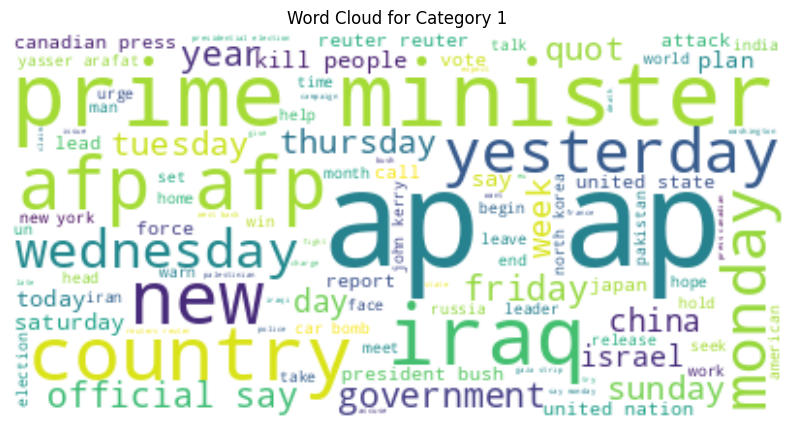

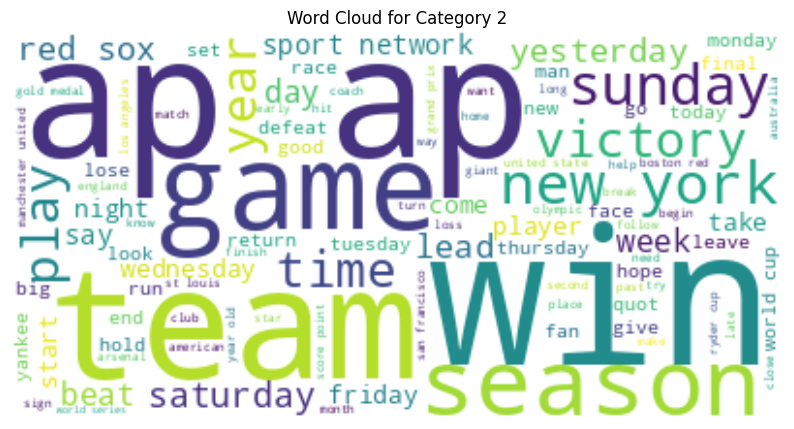

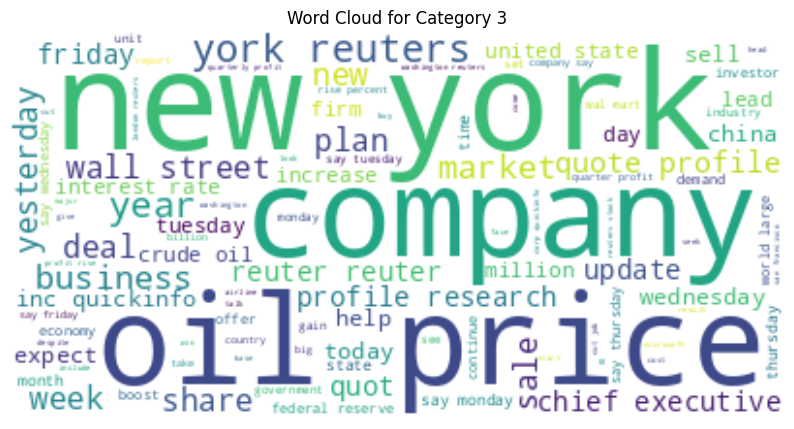

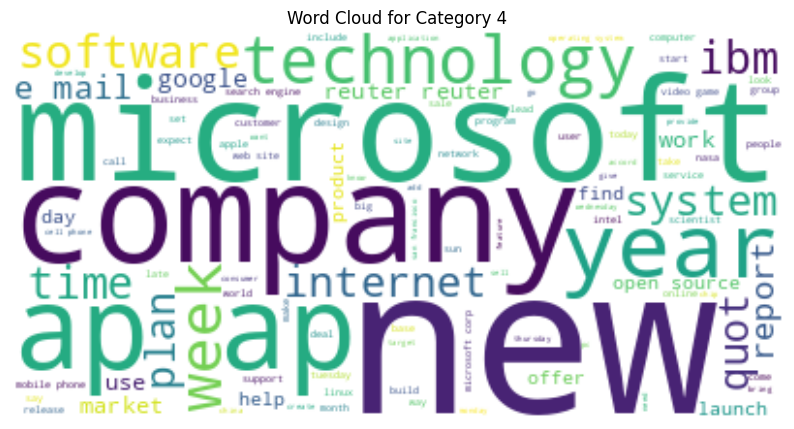

In [20]:
# Example: plot for all 4 classes
for i in range(1,5):
    plot_wordcloud(i)

# Train a Simple Neural Network (Keras)

In [21]:
model = models.Sequential([
    layers.Input(shape=(x_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax') # 4 categories
])

In [22]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=2,            # stop if no improvement for 2 epochs
    restore_best_weights=True
)

checkpoint = callbacks.ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

Received a label value of 4 which is outside the valid range of [0, 4)" means that labels are 1-indexed (1, 2, 3, 4)

The neural network is expecting 0-indexed labels (0, 1, 2, 3) for a 4-class classification problem with sparse_categorical_crossentropy. I will adjust the labels by subtracting 1 from the Class Index column.

In [24]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=20,              # we set higher, early stop will cut it short
    batch_size=128,
    callbacks=[early_stop, checkpoint],
    verbose=1)

Epoch 1/20
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7946 - loss: 0.5400
Epoch 1: val_accuracy improved from -inf to 0.31566, saving model to best_model.h5


938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.7949 - loss: 0.5395 - val_accuracy: 0.3157 - val_loss: 2.3192
Epoch 2/20
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9218 - loss: 0.2347
Epoch 2: val_accuracy did not improve from 0.31566
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.9218 - loss: 0.2347 - val_accuracy: 0.3150 - val_loss: 2.6629
Epoch 3/20
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9359 - loss: 0.1897
Epoch 3: val_accuracy did not improve from 0.31566
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.9359 - loss: 0.1897 - val_accuracy: 0.3138 - val_loss: 3.1978


In [25]:
nn_evaluation = model.evaluate(x_test, y_test)
print("Neural Net Accuracy:", nn_evaluation[1])

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3310 - loss: 2.2583
Neural Net Accuracy: 0.3156578838825226


**Plot Training Curves**

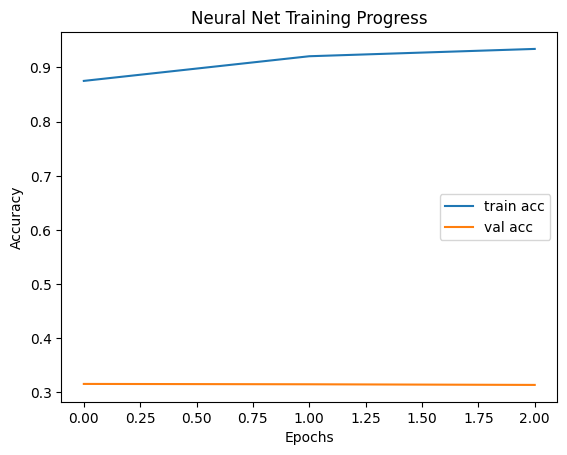

In [26]:
plt.plot(history.history['accuracy'], label="train acc")
plt.plot(history.history['val_accuracy'], label="val acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Neural Net Training Progress")
plt.show()